In [ ]:
import torch
import pandas as pd
import os
import numpy as np
import json
import h5py
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from pathlib import Path
import time

import sys
import pprint
from collections import Counter,defaultdict
from itertools import chain

class DialogDataset(Dataset):
    
    def __init__(self, json_data, image_features, img2feat, transform=None):
        
        with open(img2feat, 'r') as f:
            self.img2feat = json.load(f)['IR_imgid2id']
            
        self.img_features = np.asarray(h5py.File(image_features, 'r')['img_features'])
        self.json_data = pd.read_json(json_data, orient='index')
        self.corpus = self.get_words()
        self.vocab = list(set(self.corpus))
        self.w2i = {word : i for i, word in enumerate(self.vocab)}
        
    # collect all the words from dialogs and 
    # captions and use them to create embedding map
    def get_words(self):
        words = []
        for idx in range(len(self)):
            item = self.json_data.iloc[idx]

            # Flatten dialog and add caption into 1d array
            dialog = [word for line in item.dialog for word in line[0].split()]
            dialog.extend(item.caption.split(' '))

            words.append(dialog)
            
        return list(chain.from_iterable(words))
    
    def make_context_vector(self, context):
        idxs = [self.w2i[w] for w in context]
        tensor = torch.LongTensor(idxs)
        return autograd.Variable(tensor)

    def __len__(self):
        return len(self.json_data)

    def __getitem__(self, idx):
        item = self.json_data.iloc[idx]

        # Flatten dialog and add caption into 1d array
        dialog = [word for line in item.dialog for word in line[0].split()]
        dialog.extend(item.caption.split(' '))
        dialog = self.make_context_vector(dialog)

        img_ids = np.array(item.img_list)
        img_features = [self.img_features[idx] for idx in map(lambda x: self.img2feat[str(x)], img_ids)]
        img_features = np.array(img_features)
        img_features = Variable(torch.FloatTensor(img_features))
        
        target_idx = item.target
        
        return {'dialog' : dialog, 'img_features': img_features}, target_idx

In [ ]:
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CBOW(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.e = nn.Embedding(vocab_size, 5)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.Sigmoid()
        
        self.e = nn.Embedding(vocab_size, embedding_dim)
        

    def forward(self, inputs):
        # i believe .view() is useless here because the sum already produces a 1xEMB_DIM vector
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

In [ ]:
class MaxEnt(torch.nn.Module):
    
    def __init__(self, text_module, vocab_size, img_size):
        super(MaxEnt, self).__init__()

        self.text_module = text_module #This is de CBOW model
        self.linear = nn.Linear(vocab_size + img_size, 1)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, inp):
        dialog = inp['dialog']
        all_img_features = inp['img_features']
        
        text_features = self.text_module(dialog)
        text_features = text_features.expand((all_img_features.size(0), text_features.size(1)))
    
        concat = torch.cat((all_img_features, text_features), 1)
        
        scores = self.linear(concat)
        scores = self.softmax(scores.transpose(0, 1))
        
        return scores

In [ ]:
SAMPLE_EASY = ['Data', 'sample_easy.json']
TEST_EASY = ['Data', 'Easy', 'IR_test_easy.json']
TRAIN_EASY = ['Data', 'Easy', 'IR_train_easy.json']
TRAIN_EASY_100 = ['Data', 'Easy', 'IR_train_easy_100.json']
TRAIN_EASY_1000 = ['Data', 'Easy', 'IR_train_easy_1000.json']
TRAIN_EASY_4000 = ['Data', 'Easy', 'IR_train_easy_4000.json']
VALID_EASY = ['Data', 'Easy', 'IR_val_easy.json']
IMG_FEATURES = ['Data', 'Features', 'IR_image_features.h5']
INDEX_MAP = ['Data', 'Features', 'IR_img_features2id.json']

IMG_SIZE = 2048
EMBEDDING_DIM = 100

torch.manual_seed(1)
dialog_data = DialogDataset(os.path.join(*TRAIN_EASY), os.path.join(*IMG_FEATURES), os.path.join(*INDEX_MAP))
valid_data = DialogDataset(os.path.join(*VALID_EASY), os.path.join(*IMG_FEATURES), os.path.join(*INDEX_MAP))

vocab_size = len(dialog_data.vocab)

In [ ]:
cbow_model = CBOW(vocab_size, EMBEDDING_DIM)
max_ent = MaxEnt(cbow_model, vocab_size, IMG_SIZE)

In [ ]:
def validate(model, data, loss_func):
    total_loss = 0
    
    for i, (inp, target) in enumerate(data):
        pred = model(inp)
        target = Variable(torch.LongTensor(np.array([target])))
        
        loss = loss_func(pred, target)
        total_loss += loss
        
        if i == 20:
            break
    
    return total_loss / 20

def predict(model, data):
    correct = 0
    
    for i, (inp, target) in enumerate(data):
        pred = model(inp)
        img, idx = torch.max(pred, 1)
        if idx.data[0] == target:
            correct += 1
        
        if i == 20:
            break
    
    return correct

validate(max_ent, dialog_data, nn.NLLLoss())

In [180]:
EPOCHS = 5
EMBEDDING_DIM = 1000

cbow_model = CBOW(vocab_size, EMBEDDING_DIM)
max_ent = MaxEnt(cbow_model, vocab_size, IMG_SIZE)
loss_func = nn.NLLLoss()
optimizer = optim.Adam(max_ent.parameters(), lr=1e-05)
validation_errors = []

def train(training_portion=100, validation_portion=20, logging=True):
    
    if logging == True:
        timestr = time.strftime("%m-%d-%H-%M")
        custom_label = "custom_label"
        filename = "{}-t_size_{}-v_size_{}-emb_{}-eps_{}-dt_{}.txt".format(custom_label,
                                                                           training_portion,
                                                                           validation_portion,
                                                                           EMBEDDING_DIM,
                                                                           EPOCHS,
                                                                           timestr)
        
        stats_log = open("Training_recordings/" + filename, 'w')
        stats_log.write("EPOCH|AVG_LOSS|TOT_LOSS|VAL_ERROR|CORRECT\n")
        print("Logging enabled in:", filename)
        
    else:
        print("Logging disabled!")
        filename = ""
        

    for epoch in range(1, EPOCHS + 1):
        total_loss = 0
        for i, (inp, target) in enumerate(dialog_data):

            pred = max_ent(inp)

            target = Variable(torch.LongTensor(np.array([target])))

            loss = loss_func(pred, target)
            total_loss += loss.data[0]

            max_ent.zero_grad()

            loss.backward()
            optimizer.step()

            if i == training_portion:
                break

        avg_loss = total_loss / training_portion
        print("Epoch {}, Average Loss: {}".format(epoch, avg_loss))
        val_prediction = predict(max_ent, valid_data)
        print("Predicted {}/{} samples correctly".format(val_prediction, validation_portion))

        val = validate(max_ent, valid_data, loss_func)
        validation_errors.append(val.data[0])
        
        if logging == True:
            stats_log.write("{}|{}|{}|{}|{}\n".format(epoch, avg_loss, total_loss, val.data[0], val_prediction))
    
    print("Done, validation errors: ", validation_errors)
    
    return filename

trained_stats_file = train()

Logging enabled in: custom_label-t_size_100-v_size_20-emb_1000-eps_5-dt_12-14-21-37.txt
Epoch 1, Average Loss: 2.330298466682434
Predicted 1/20 samples correctly
Epoch 2, Average Loss: 2.31715537071228
Predicted 2/20 samples correctly
Epoch 3, Average Loss: 2.3051445126533507
Predicted 2/20 samples correctly
Epoch 4, Average Loss: 2.2934996271133423
Predicted 7/20 samples correctly
Epoch 5, Average Loss: 2.2822064423561095
Predicted 7/20 samples correctly
Done, validation errors:  [2.4146156311035156, 2.407346487045288, 2.400367259979248, 2.393667697906494, 2.387235164642334]


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
np.random.seed(sum(map(ord, "aesthetics")))

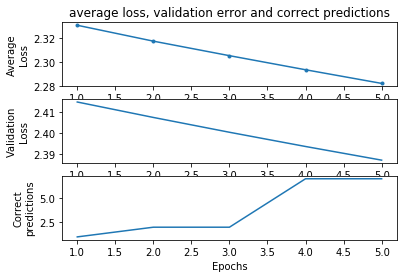

In [182]:
def draw_graph(filename=trained_stats_file):
    
    
    # Read file and data
    with open("Training_recordings/" + filename, 'r') as f:
        data = [x.strip() for x in f.readlines()] 
    
    data = np.array([line.split("|") for line in data[1:]]).T
    
    epochs, avg_loss, total_loss, val_error, correct_pred = data
    
    epochs = np.array(epochs, dtype=np.int8)
    
    plt.subplot(3, 1, 1)
    plt.plot(epochs, np.array(avg_loss, dtype=np.float32), '.-')
    plt.title('average loss, validation error and correct predictions')
    plt.ylabel('Average\nLoss')
    plt.xlabel('Epochs')

    plt.subplot(3, 1, 2)
    plt.plot(epochs, np.array(val_error, dtype=np.float32), '-')
    plt.ylabel('Validation\nLoss')
    plt.xlabel('Epochs')

    plt.subplot(3, 1, 3)
    plt.plot(epochs, np.array(correct_pred, dtype=np.int8), '-')
    plt.ylabel('Correct\npredictions')
    plt.xlabel('Epochs')

   
    
    
    plt.show()

draw_graph()